In [15]:
import pandas as pd
from tqdm import tqdm

paper_stats_publication_classified = pd.read_csv("data/0510-citation-pub-data-publication-classified.csv")
paper_stats_speaker_order = pd.read_csv("data/0510-citation-pub-data-speaker-order-absolute.csv")

author_stats = pd.read_csv("data/0721-month-analysis-data-merged-5.csv")

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_82970/2561078361.py:4: DtypeWarning: Columns (12,21,22,24,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  paper_stats_publication_classified = pd.read_csv("data/0510-citation-pub-data-publication-classified.csv")
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_82970/2561078361.py:5: DtypeWarning: Columns (12,21,22,24,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  paper_stats_speaker_order = pd.read_csv("data/0510-citation-pub-data-speaker-order-absolute.csv")


In [16]:
# Merge the dataframes column-wise, avoiding duplicate columns
paper_stats = pd.concat([paper_stats_publication_classified, paper_stats_speaker_order.loc[:, ~paper_stats_speaker_order.columns.isin(paper_stats_publication_classified.columns)]], axis=1)

# Display the merged dataframe
print("Paper stats original: ", [col for col in list(paper_stats.columns) if "Researcher" in col])

Paper stats original:  ['Researcher of Interest', 'Researcher Cleaned Name', 'Researcher Cleaned Classification']


In [17]:
from rapidfuzz.process import extractOne

author_authors = author_stats["Researcher Cleaned Name"].unique()
paper_authors = paper_stats["Researcher of Interest"].unique()
author_map = {}

for paper_author in paper_authors:
    author_map[paper_author] = extractOne(paper_author, author_authors)[0]

paper_stats["Researcher of Interest Mapped"] = paper_stats["Researcher of Interest"].map(author_map)


In [18]:
print("Paper stats columns: ", [col for col in list(paper_stats.columns) if "Researcher" in col])
print("Author stats columns: ", [col for col in list(author_stats.columns) if "Researcher" in col])

Paper stats columns:  ['Researcher of Interest', 'Researcher Cleaned Name', 'Researcher Cleaned Classification', 'Researcher of Interest Mapped']
Author stats columns:  ['Researcher Cleaned Name', 'Researcher Classification']


In [19]:
print("Author stats: ", author_stats.shape)

Author stats:  (36973, 61)


In [20]:
print("Paper months stats: ", paper_stats["month"].value_counts())
print("NaN month counts: ", paper_stats["month"].isna().sum())
print("Not NaN month counts: ", paper_stats["month"].notna().sum())

Paper months stats:  month
6.0     7595
10.0    7114
5.0     6944
12.0    6771
7.0     6264
11.0    6079
9.0     5951
1.0     5757
4.0     5606
8.0     5498
3.0     5322
2.0     3808
Name: count, dtype: int64
NaN month counts:  27155
Not NaN month counts:  72709


In [21]:
import pandas as pd
from tqdm import tqdm

# Ensure tqdm works well with pandas apply for better progress tracking
tqdm.pandas()

pub_types = paper_stats["publication_type"].unique()

# Join the dataframes on "Researcher Cleaned Name", "year", and "month"
merged = author_stats.merge(
    paper_stats,
    left_on=["Researcher Cleaned Name", "year", "month"],
    right_on=["Researcher of Interest Mapped", "year", "month"],
    how="left",
)

print("Merged columns: ", list(merged.columns))

# Aggregate data for efficiency
group_keys = ["Researcher of Interest Mapped", "year", "month"]
grouped = merged.groupby(group_keys)

# Calculate statistics
stats = grouped.agg(
    avg_speaker_rank_abs=("Speaker Rank Absolute", "mean"),
    avg_speaker_rank_rel=("Speaker Rank", "mean"),
    first_author_count=("Speaker Rank Absolute", lambda x: (x == 1).sum()),
    last_author_count=("Speaker Rank", lambda x: (x == 1).sum()),
)

# Add first_or_last_author stats
stats["first_or_last_author_count"] = (
    stats["first_author_count"] + stats["last_author_count"]
)

stats["first_author_prop"] = stats["first_author_count"] / grouped.size()
stats["last_author_prop"] = stats["last_author_count"] / grouped.size()
stats["first_or_last_author_prop"] = stats["first_or_last_author_count"] / grouped.size()

# Calculate publication type counts
for pub_type in pub_types:
    stats[f"{pub_type}_count"] = grouped.apply(
        lambda g: (g["publication_type"] == pub_type).sum()
    )
    

Merged columns:  ['Researcher Cleaned Name_x', 'year', 'month', 'num_sg_mean', 'num_sg_error', 'num_hk_mean', 'num_hk_error', 'num_ml_mean', 'num_ml_error', 'num_other_mean', 'num_other_error', 'teamsize_mean', 'teamsize_error', 'prop_sg_mean', 'prop_sg_error', 'prop_hk_mean', 'prop_hk_error', 'prop_ml_mean', 'prop_ml_error', 'prop_other_mean', 'prop_other_error', 'total_citations_mean', 'total_citations_error', 'Name', 'Researcher Classification', 'Left after 2014', 'PhD Location', 'Master Location', 'Bachelor Location', 'Leaving Region', 'Join Year', 'Join Month', 'PhD Year', 'Master Year', 'Bachelor Year', 'Department', 'Title', 'First Year', 'Leaving Year', 'Leaving Month', 'Academic Age', 'Pre-2014 School', 'Post Event', 'Pre-2014 Region', 'Number of Publications', 'general_analysis', 'cross_group_thinking_ideas', 'cross_group_thinking_score', 'unifying_language_ideas', 'unifying_language_score', 'shared_initiatives_outreach_ideas', 'shared_initiatives_outreach_score', 'importance

/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_82970/1331099285.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats[f"{pub_type}_count"] = grouped.apply(
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_82970/1331099285.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats[f"{pub_type}_count"] = grouped.apply(
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_82970

In [22]:

# Reset index to merge back into the original dataframe
stats = stats.reset_index()
print("stats columns: ", list(stats.columns))
print("author stats columns: ", list(author_stats.columns))

stats["Researcher Cleaned Name"] = stats["Researcher of Interest Mapped"]

# Merge calculated stats back into author_stats
author_stats = author_stats.merge(stats, on=["Researcher Cleaned Name", "year", "month"], how="left")

stats columns:  ['Researcher of Interest Mapped', 'year', 'month', 'avg_speaker_rank_abs', 'avg_speaker_rank_rel', 'first_author_count', 'last_author_count', 'first_or_last_author_count', 'first_author_prop', 'last_author_prop', 'first_or_last_author_prop', 'journal_count', 'empty_journal_publisher_count', 'preprint_count', 'conference_count', 'other_count', 'institutional_count', 'book_count']
author stats columns:  ['Researcher Cleaned Name', 'year', 'month', 'num_sg_mean', 'num_sg_error', 'num_hk_mean', 'num_hk_error', 'num_ml_mean', 'num_ml_error', 'num_other_mean', 'num_other_error', 'teamsize_mean', 'teamsize_error', 'prop_sg_mean', 'prop_sg_error', 'prop_hk_mean', 'prop_hk_error', 'prop_ml_mean', 'prop_ml_error', 'prop_other_mean', 'prop_other_error', 'total_citations_mean', 'total_citations_error', 'Name', 'Researcher Classification', 'Left after 2014', 'PhD Location', 'Master Location', 'Bachelor Location', 'Leaving Region', 'Join Year', 'Join Month', 'PhD Year', 'Master Year'

In [23]:
if "index" in author_stats.columns:
    del author_stats["index"]
print("Columns: ", author_stats.columns)


Columns:  Index(['Researcher Cleaned Name', 'year', 'month', 'num_sg_mean',
       'num_sg_error', 'num_hk_mean', 'num_hk_error', 'num_ml_mean',
       'num_ml_error', 'num_other_mean', 'num_other_error', 'teamsize_mean',
       'teamsize_error', 'prop_sg_mean', 'prop_sg_error', 'prop_hk_mean',
       'prop_hk_error', 'prop_ml_mean', 'prop_ml_error', 'prop_other_mean',
       'prop_other_error', 'total_citations_mean', 'total_citations_error',
       'Name', 'Researcher Classification', 'Left after 2014', 'PhD Location',
       'Master Location', 'Bachelor Location', 'Leaving Region', 'Join Year',
       'Join Month', 'PhD Year', 'Master Year', 'Bachelor Year', 'Department',
       'Title', 'First Year', 'Leaving Year', 'Leaving Month', 'Academic Age',
       'Pre-2014 School', 'Post Event', 'Pre-2014 Region',
       'Number of Publications', 'general_analysis',
       'cross_group_thinking_ideas', 'cross_group_thinking_score',
       'unifying_language_ideas', 'unifying_language_score

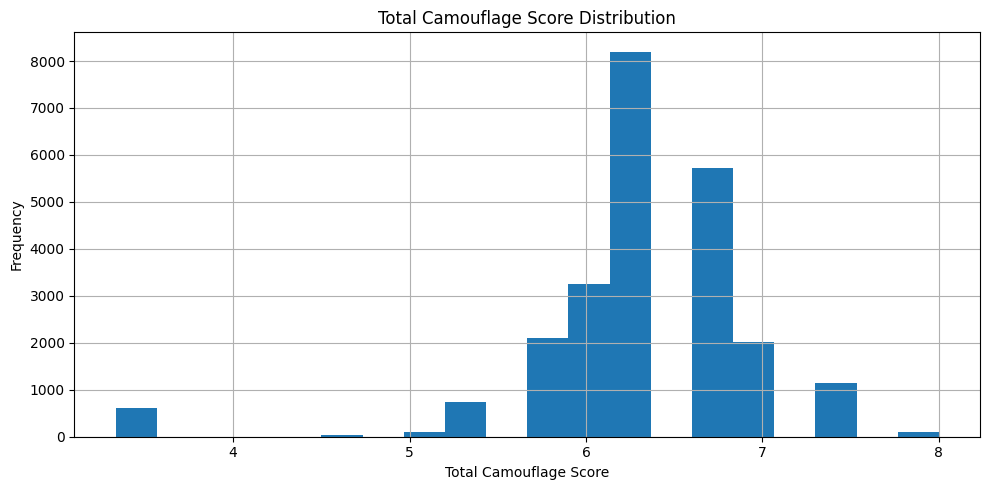

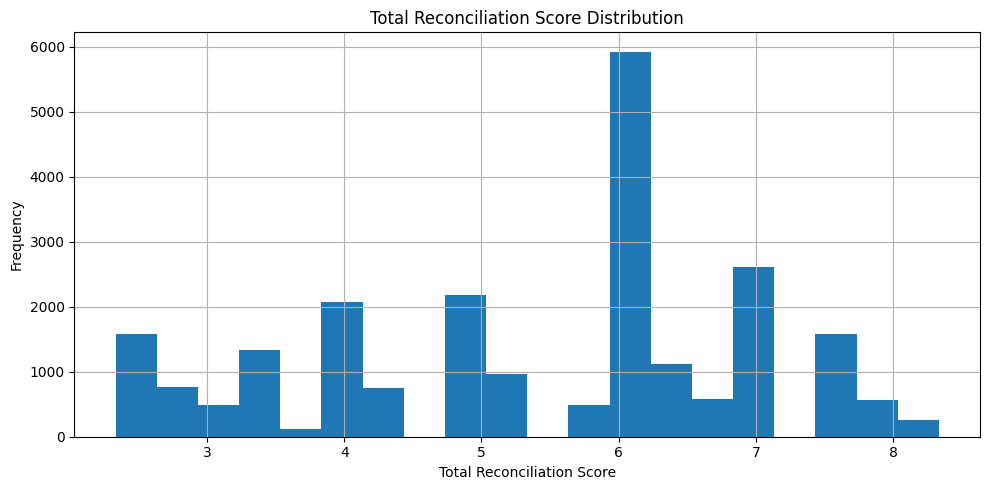

In [25]:
import matplotlib.pyplot as plt

# Plot the Total Camouflage Score Distribution
plt.figure(figsize=(10, 5))
plt.title("Total Camouflage Score Distribution")
plt.xlabel("Total Camouflage Score")
plt.ylabel("Frequency")
author_stats["total_camouflage_score"][author_stats["total_camouflage_score"] > 0].hist(bins=20)
plt.tight_layout()  # Adjust layout after adding title and labels
plt.show()

# Plot the Total Reconciliation Score Distribution
plt.figure(figsize=(10, 5))
plt.title("Total Reconciliation Score Distribution")
plt.xlabel("Total Reconciliation Score")
plt.ylabel("Frequency")
author_stats["total_reconciliation_score"][author_stats["total_reconciliation_score"] > 0].hist(bins=20)
plt.tight_layout()  # Adjust layout after adding title and labels
plt.show()


In [24]:
author_stats.to_csv("data/0721-month-analysis-data-merged-monthly-publication-stats-2.csv", index=False)